# 802.11a/g 解调

In [2]:
import math
import numpy as np
from numpy import real, imag, angle
import matplotlib.pyplot as plt
from scipy import signal
from numpy.fft import ifft, fft, fftshift
import viterbi

%matplotlib widget

In [3]:
FS = 20e6
LTS_F = np.load("lts.npy")
LTS_T = ifft(fftshift(LTS_F))
LTS_LEN = 64
STS_LEN = 16
CP_LEN = 16
N = 64
DATA_IND = np.hstack((np.arange(6, 11), np.arange(12, 25), np.arange(26, 32), np.arange(33, 39), np.arange(40, 53), np.arange(54, 59)))
PILOT_IND = np.array([11, 25, 39, 53])
PILOT_SCRAMBLE = np.load("pilot.npy")
DATA_SCRAMBLE = np.load("scramble.npy")

RATE_BITS = {
    '1101': 6,
    '1111': 9,
    '0101': 12,
    '0111': 18,
    '1001': 24,
    '1011': 36,
    '0001': 48,
    '0011': 54,
}

# rate : (n_bpsc, n_cbps, n_dbps)
RATE_PARAMETERS = {
    6: (1, 48, 24),
    9: (1, 48, 36),
    12: (2, 96, 48),
    18: (2, 96, 72),
    24: (4, 192, 96),
    36: (4, 192, 144),
    48: (6, 288, 192),
    54: (6, 288, 216),
}

def power_detector(sig, window_len):
    sig = np.abs(sig)
    a = np.convolve(sig[:-window_len], np.ones(window_len), "same")
    b = np.convolve(sig[window_len:], np.ones(window_len), "same")
    return 10 * np.log10(b / a)

class WIFIDecoder:
    def __init__(self, lts_f, sts_len, cp_len, fs):
        self.lts_f = lts_f
        self.lts_t = ifft(fftshift(lts_f))
        self.lts_len = len(lts_f)
        self.sts_len = sts_len
        self.cp_len = cp_len
        self.fs = fs

    def find_packet_edge(self, sig, threshoud):
        sts_len = self.sts_len
        corr = sig[:-sts_len] * np.conj(sig[sts_len:])
        power = sig[sts_len:] * np.conj(sig[sts_len:])
        corr_sum = np.convolve(corr, np.ones(sts_len), "same")
        power_sum = np.convolve(power, np.ones(sts_len), "same")
        decision = corr > power
        decision = corr_sum > power_sum * threshoud
        peaks = signal.find_peaks(decision, width=128)
        if len(peaks) > 0:
            return peaks[1]["left_bases"][0] - sts_len
        else:
            return 0

    def fine_time_sync(self, sig, threshoud):
        lts_t = self.lts_t
        lts_len = self.lts_len
        cp_len = self.cp_len
        corr = signal.correlate(sig, lts_t, "same")
        lts_pos, _ = signal.find_peaks(np.abs(corr), height=threshoud)
        if len(lts_pos) < 1:
            return 0
        return lts_pos[0] - 32

    def coarse_cfo_estimate(self, sig):
        sig = sig[16:]
        sts_len = self.sts_len
        sts_seq_1 = sig[1 * sts_len : 8 * sts_len]
        sts_seq_2 = sig[2 * sts_len : 9 * sts_len]
        cfo_est_sts = angle(np.sum(sts_seq_2 * np.conj(sts_seq_1)))
        cfo_est_sts = -cfo_est_sts / (2 * np.pi * sts_len / self.fs)
        return cfo_est_sts

    def fine_cfo_estimate(self, sig):
        lts_len = self.lts_len
        lts1 = sig[0 * lts_len: 1 * lts_len]
        lts2 = sig[1 * lts_len: 2 * lts_len]
        cfo_est_lts = angle(np.sum(lts2 * np.conj(lts1)));
        cfo_est_lts = -cfo_est_lts / (2 * np.pi * lts_len / self.fs);
        return cfo_est_lts

    def freq_compensation(self, sig, freq_offset):
        return sig * np.exp(
            1j * 2 * np.pi * freq_offset * (np.arange(len(sig)) / self.fs)
        )

    def channel_estimate(self, sig):
        lts_len = self.lts_len
        lts_f = fftshift(self.lts_f)
        lts1 = sig[0 * lts_len: 1 * lts_len]
        lts2 = sig[1 * lts_len: 2 * lts_len]
        lts1_f = fft(lts1)
        lts2_f = fft(lts2)
        h1 = lts_f / lts1_f
        h2 = lts_f / lts2_f
        return (h1 + h2) / 2
    
    def pilot_phase_estimate(self, pilot_symbols):
        pilot_symbols_true = np.repeat(PILOT_SCRAMBLE, 4).reshape(-1, 4) * [1, 1, 1, -1]
        pilot_symbols_true = np.tile(pilot_symbols_true, (pilot_symbols.shape[0] // pilot_symbols_true.shape[0] + 1, 1))
        pilot_symbols_true = pilot_symbols_true[:pilot_symbols.shape[0],:]
        phases = angle(np.average((np.conj(pilot_symbols_true) * pilot_symbols), axis=-1))
        phases = np.exp(-1j * phases)[:,None]
        return phases

In [5]:
sig = np.memmap("iq.dat", dtype=np.complex64)
power_trigger = power_detector(sig, window_len=500)
frame_start_pos, _ = signal.find_peaks(power_trigger > 8)

def get_frame(index):
    return sig[frame_start_pos[index]:frame_start_pos[index]+42000]

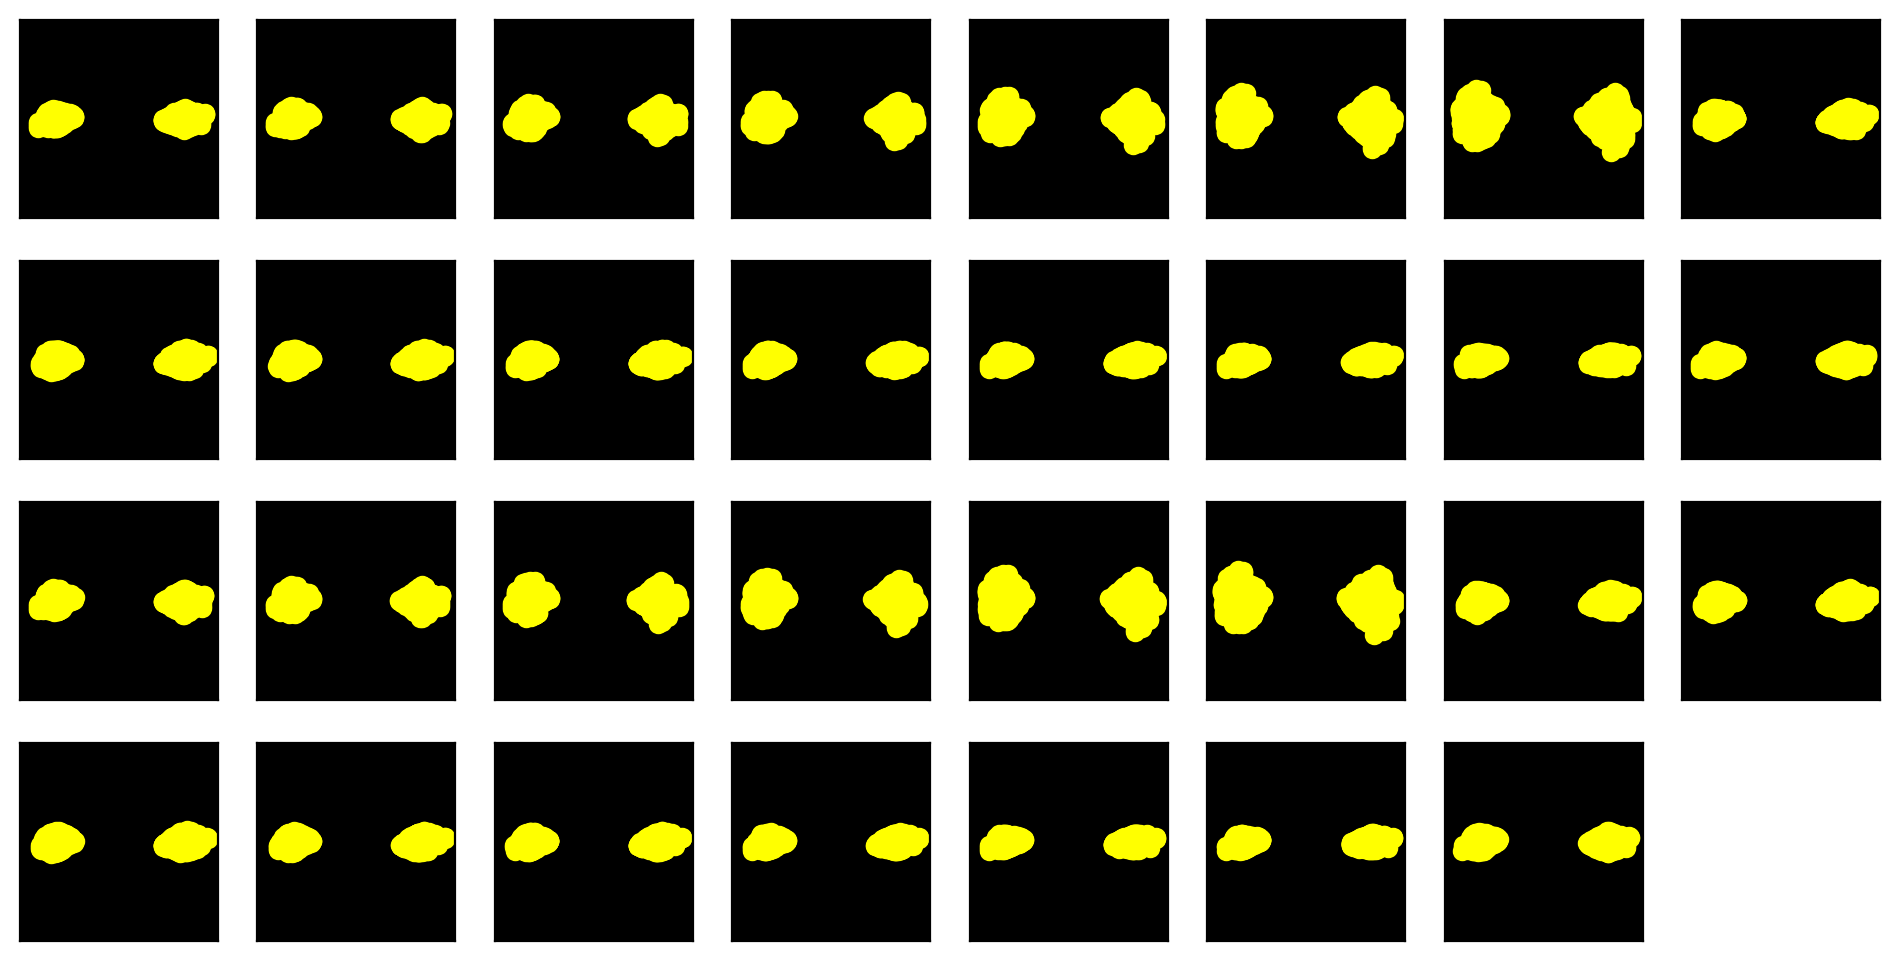

In [20]:
def decode_frame(frame, wifi_decoder):
    pos = wifi_decoder.find_packet_edge(frame, 0.9)
    frame = frame[pos:]

    # 粗略载波频率偏移估计
    coarse_cfo = wifi_decoder.coarse_cfo_estimate(frame)
    frame = wifi_decoder.freq_compensation(frame, coarse_cfo)
    # 精细时间对齐(LTS)
    pos = wifi_decoder.fine_time_sync(frame, 0.2)
    frame = frame[pos:]

    # 精细载波频率偏移估计
    fine_cfo = wifi_decoder.fine_cfo_estimate(frame)
    frame = wifi_decoder.freq_compensation(frame, fine_cfo)
    # 信道参数估计
    channel_estimate = wifi_decoder.channel_estimate(frame)
    frame = frame[2 * LTS_LEN:]
    # 解调502个符号
    frame = frame[:(N + CP_LEN) * 502]
    # 变换成[502(行) * 符号长度(列)]的矩阵
    frame = frame.reshape(502, N + CP_LEN)
    # 去除CP
    frame = frame[:,CP_LEN:]
    # 时域转频域
    frame = fft(frame, axis=-1)
    # 使用信道参数纠正
    frame = frame * channel_estimate
    frame = fftshift(frame, axes=-1)

    # 数据信道
    data_symbols = frame[:,DATA_IND]
    # 导频信道
    pilot_symbols = frame[:,PILOT_IND]

    # 通过导频相位补偿
    phases = wifi_decoder.pilot_phase_estimate(pilot_symbols)
    data_symbols *= phases
    return data_symbols


wifi_decoder = WIFIDecoder(lts_f=LTS_F, sts_len=STS_LEN, cp_len=CP_LEN, fs=FS)

%matplotlib inline
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots(4, 8)
fig.set_size_inches(12, 6)

ax = ax.reshape(-1)
ax[-1].remove()

for i in range(31):
    data_symbols = decode_frame(get_frame(i), wifi_decoder)
    # 绘制星座图
    data = data_symbols.reshape(-1)
    axes = ax[i]
    axes.grid(True)
    axes.set_aspect(1)
    axes.set_facecolor("black")
    axes.set_xlim(-1.5, 1.5)
    axes.set_ylim(-1.5, 1.5)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.scatter(np.real(data), np.imag(data), color="yellow")
plt.show()

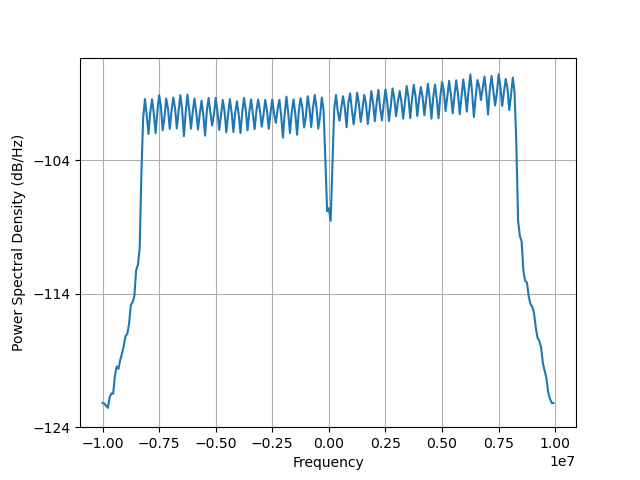

-2281.2535378659863
-186.25347476863848


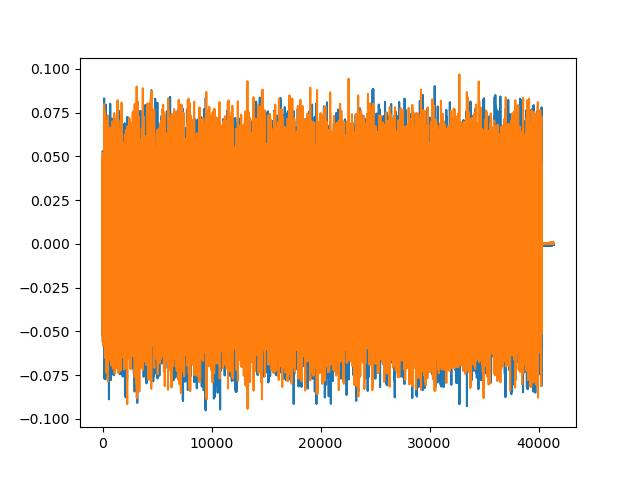

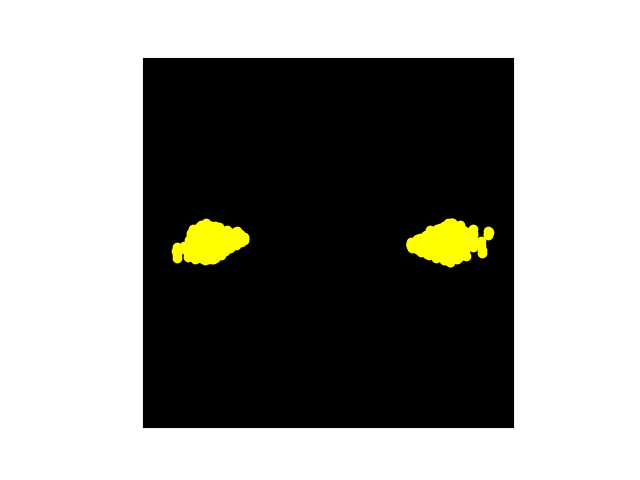

In [21]:
%matplotlib widget

frame = get_frame(0)

pos = wifi_decoder.find_packet_edge(frame, 0.9)
frame = frame[pos:]

plt.figure()
plt.psd(frame, Fs=20e6)
plt.show()

# 粗略载波频率偏移估计
coarse_cfo = wifi_decoder.coarse_cfo_estimate(frame)
print(coarse_cfo)
frame = wifi_decoder.freq_compensation(frame, coarse_cfo)
# 精细时间对齐(LTS)
pos = wifi_decoder.fine_time_sync(frame, 0.2)
frame = frame[pos:]

# 精细载波频率偏移估计
fine_cfo = wifi_decoder.fine_cfo_estimate(frame)
print(fine_cfo)
frame = wifi_decoder.freq_compensation(frame, fine_cfo)

plt.figure()
plt.plot(frame.real)
plt.plot(frame.imag)
plt.show()

# 信道参数估计
channel_estimate = wifi_decoder.channel_estimate(frame)
frame = frame[2 * LTS_LEN:]
# 解调502个符号
frame = frame[:(N + CP_LEN) * 502]
# 变换成[502(行) * 符号长度(列)]的矩阵
frame = frame.reshape(502, N + CP_LEN)
# 去除CP
frame = frame[:,CP_LEN:]
# 时域转频域
frame = fft(frame, axis=-1)
# 使用信道参数纠正
frame = frame * channel_estimate
frame = fftshift(frame, axes=-1)

# 数据信道
data_symbols = frame[:,DATA_IND]
# 导频信道
pilot_symbols = frame[:,PILOT_IND]

# 通过导频相位补偿
phases = wifi_decoder.pilot_phase_estimate(pilot_symbols)
data_symbols *= phases


plt.figure()
axes = plt.gca()
axes.grid(True)
axes.set_aspect(1)
axes.set_facecolor("black")
axes.set_xlim(-1.5, 1.5)
axes.set_ylim(-1.5, 1.5)
axes.set_xticks([])
axes.set_yticks([])
plt.scatter(data_symbols.real, data_symbols.imag, color="yellow")
# plt.plot()
plt.show()

In [22]:
# data_symbols = decode_frame(get_frame(0), wifi_decoder)
signal_symbol = (data_symbols[0].real > 0).astype(np.int32)

tb_depth = 35
cc = fec.FECConv(("1011011", "1111001"), tb_depth)

class Signal:
    def __init__(self, bits):
        assert len(bits) == 24
        str_bits = ''.join([str(b) for b in bits])
        self.rate_bits = str_bits[:4]
        self.rsvd = str_bits[4]
        self.len_bits = str_bits[5:17]
        self.parity_bits = str_bits[17]
        self.tail_bits = str_bits[18:]

        self.mcs = 0
        self.rate = RATE_BITS.get(self.rate_bits, 0)
        self.length = int(self.len_bits[::-1], 2)
        self.parity_ok = sum(bits[:18]) % 2 == 0
        self.ht = False
        self.mcs = 0

def deinterleave(in_bits, rate=6):
    n_bpsc, n_cbps, n_dbps = RATE_PARAMETERS[rate]
    n_col = 16
    n_row = 3 * n_bpsc

    s = max(n_bpsc / 2, 1)

    first_perm = np.zeros(n_cbps, np.int32)
    for j in range(0, n_cbps):
        first_perm[j] = (s * (j // s)) + ((j + n_col * j // n_cbps) % s)

    second_perm = np.zeros(n_cbps, np.int32)
    for i in range(0, n_cbps):
        second_perm[i] = n_col * i - (n_cbps - 1) * (i // n_row)

    perm = second_perm[first_perm[np.arange(n_cbps)]]
    perm = np.tile(perm, len(in_bits) // n_cbps + 1)[:len(in_bits)]
    perm += np.arange(len(in_bits)) // n_cbps * n_cbps

    out_bits = np.zeros(len(in_bits), np.int32)
    out_bits[perm] = in_bits
    return out_bits

def descramble(in_bits):
    scramble_seq = np.tile(DATA_SCRAMBLE, len(in_bits) // len(DATA_SCRAMBLE) + 1)[:len(in_bits)]
    return in_bits ^ scramble_seq


signal_symbol = deinterleave(signal_symbol)
signal_symbol = cc.viterbi_decoder(np.hstack((signal_symbol, np.zeros(tb_depth*2-2, np.int32))), "hard")
signal_field = Signal(signal_symbol.astype(np.int32))
print(signal_field.length)
print(signal_field.rate)
print(signal_field.parity_ok)

data_symbol_len = math.ceil((22 + 8 * signal_field.length) / 24);
print(data_symbol_len)

1500
6
True
501


In [39]:
data_bits = (data_symbols[1:].reshape(-1).real > 0).astype(np.int32)
data_bits = deinterleave(data_bits, signal_field.rate)
data_bits = viterbi.decode(data_bits)
data_bits = np.array(data_bits)

In [40]:
data_bits_1 = descramble(data_bits.astype(np.int32))[16:]
psdu = np.packbits(data_bits_1.astype(np.int32), bitorder="little")
psdu = psdu[:signal_field.length]
print(psdu.shape)

def hexdump(bytes_input, width=16):
    current = 0
    end = len(bytes_input)
    result = "┌────────┬─" + "─" * 3 * width + "┬─" + "─" * width + "─┐\n"
    while current < end:
        result += "│%08x│ " % current
        byte_slice = bytes_input[current : current + width]
        for b in byte_slice:
            result += "%02x " % b
        for _ in range(width - len(byte_slice)):
            result += " " * 3
        result += "│ "
        for b in byte_slice:
            if (b >= 32) and (b < 127):
                result += chr(b)
            else:
                result += "."
        for _ in range(width - len(byte_slice)):
            result += " "
        result += " │\n"
        current += width
    result += "└────────┴─" + "─" * 3 * width + "┴─" + "─" * width + "─┘"
    return result

print(hexdump(psdu))

(1500,)
┌────────┬─────────────────────────────────────────────────┬──────────────────┐
│00000000│ 08 00 0f ba 00 60 08 cd 37 a6 00 20 d6 01 3c f1 │ .....`..7.. ..<. │
│00000010│ 00 60 08 ad 3b af 06 70 00 00 00 00 00 00 00 00 │ .`..;..p........ │
│00000020│ 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 │ ................ │
│00000030│ 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 │ ................ │
│00000040│ 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 │ ................ │
│00000050│ 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 │ ................ │
│00000060│ 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 │ ................ │
│00000070│ 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 │ ................ │
│00000080│ 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 │ ................ │
│00000090│ 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 │ ................ │
│000000a0│ 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 │ ................ │
│000000b0│ 00 00 00 00 00 00 00 

In [38]:
import binascii
from struct import unpack

psdu_buf = psdu.tobytes()

crc_calc = binascii.crc32(psdu[:-4])
print(crc_calc)
crc_real = unpack("I", psdu[-4:])
print(crc_real)

3944635804
(0,)
